In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json
# import cabinetry

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
import pyhf
from pyhf.contrib.viz import brazil
# pyhf.set_backend('jax')

import pymc as pm
import arviz as az

from Bayesian_pyhf import infer
from Bayesian_pyhf import plotting

%load_ext autoreload
%autoreload 

In [3]:
blue = '#7CA1CC' # '#A8B6CC'
rosa =  '#E57A77'

# Playing around with a SH4b workspace

### Bayesian

In [2]:
mS = 170
mH = 125
mSH = 400

with open(f'/home/iwsatlas1/mhorstm/SH4b/gp-for-flows/Notebooks/Workspaces/WorkspaceCombFit_alpha1.1_year16_17_18_SR_{mH}_{mS}_mSH{mSH}.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
workspace

model = workspace.model()

data = workspace.data(model, include_auxdata=False)

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]}
}

act_aux_data = workspace.data(model)
n_draws = 20_000

In [3]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [FlowHistoSys_lambda46]
>Metropolis: [FlowHistoSys_lambda47]
>Metropolis: [FlowHistoSys_lambda48]
>Metropolis: [FlowHistoSys_lambda49]
>Metropolis: [FlowHistoSys_lambda50]
>Metropolis: [mu]
>Metropolis: [GP]


/home/iwsatlas1/mhorstm/.local/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 69 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, FlowHistoSys_lambda46, FlowHistoSys_lambda47, FlowHistoSys_lambda48, FlowHistoSys_lambda49, FlowHistoSys_lambda50, GP, mu]


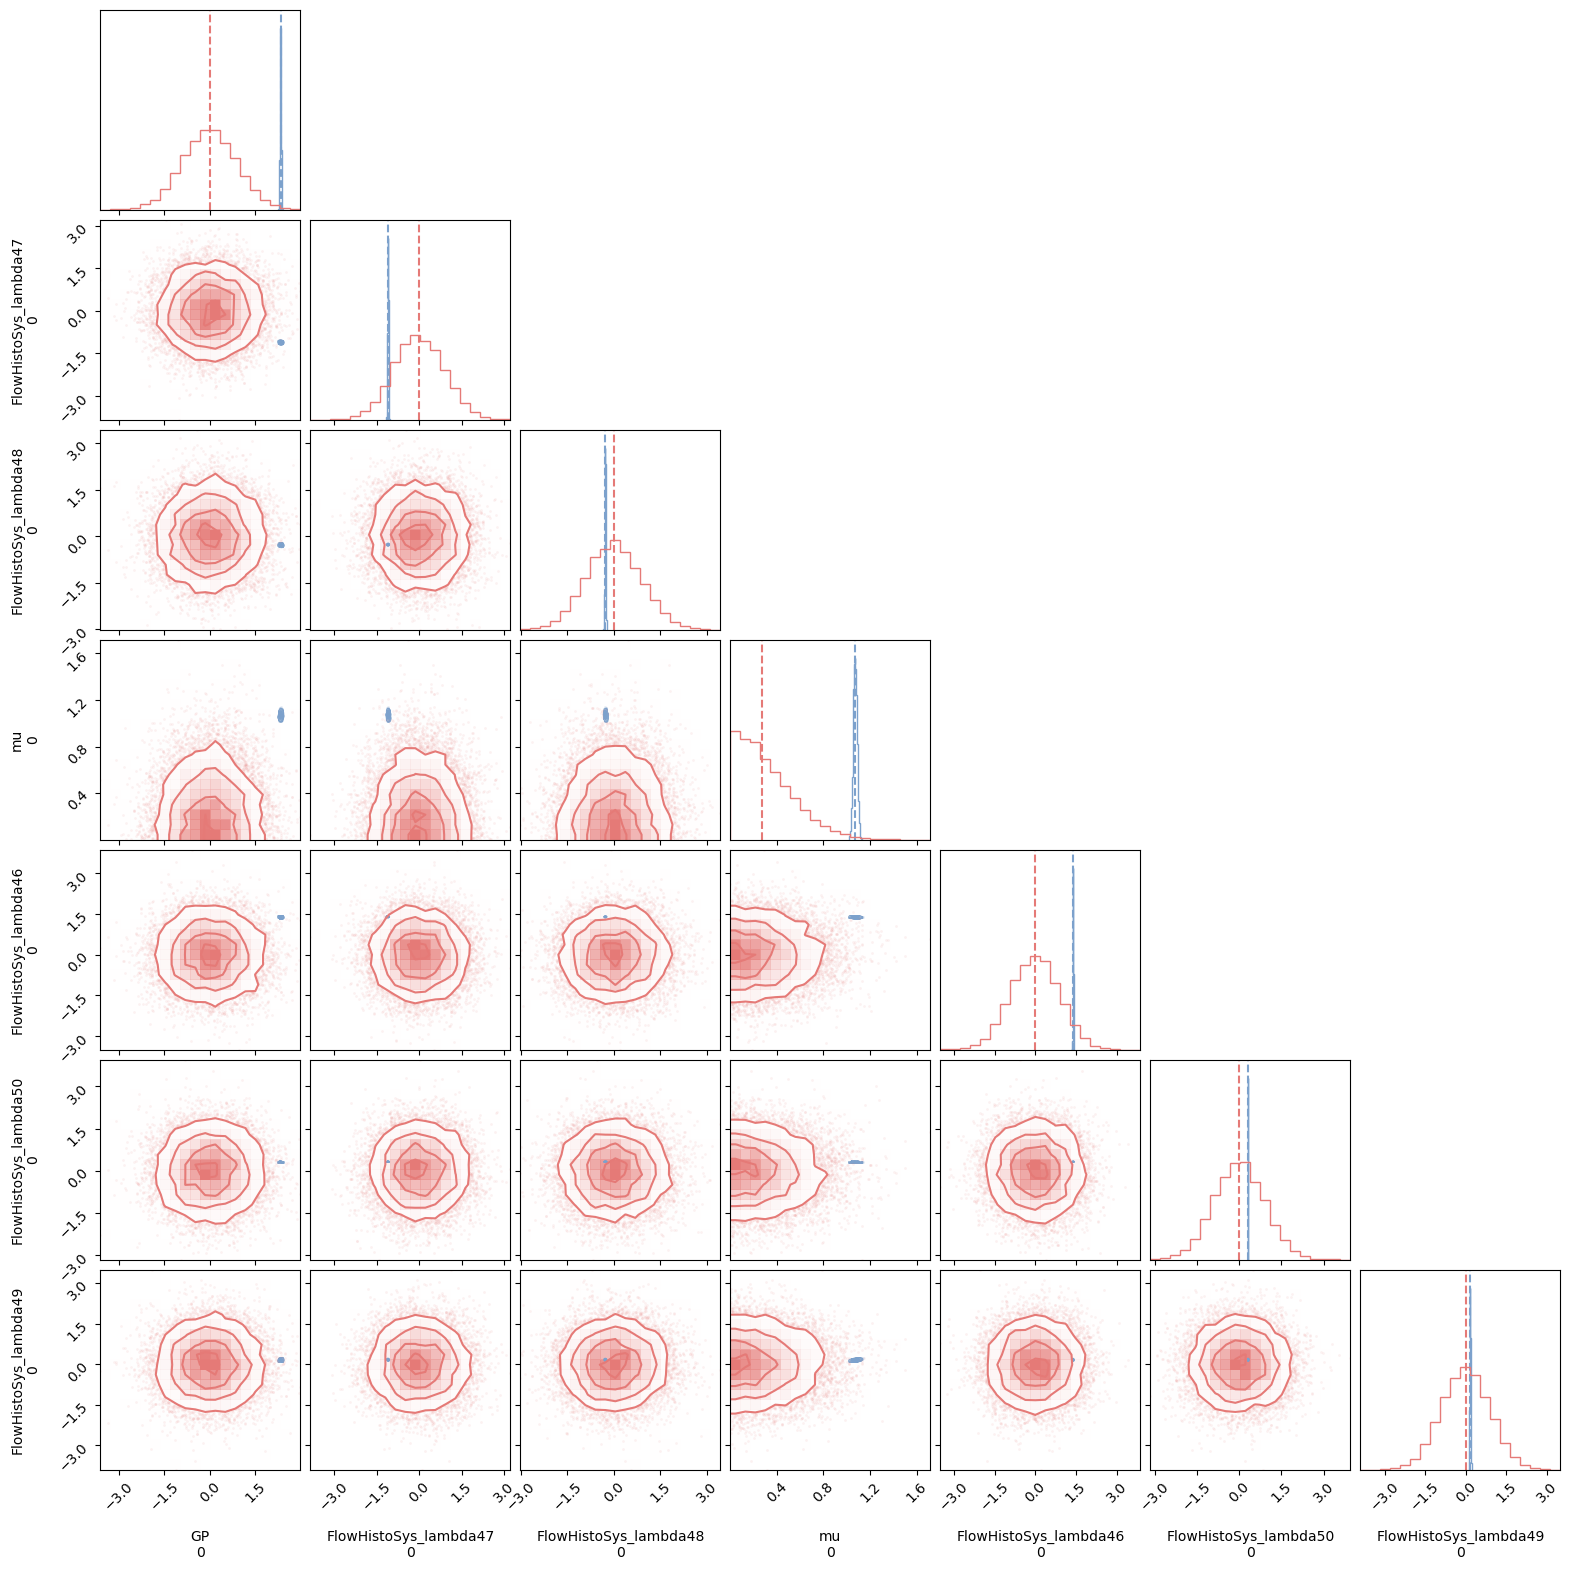

In [9]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(prior_pred.prior, quantiles=[0.5], color = rosa, fig = a);

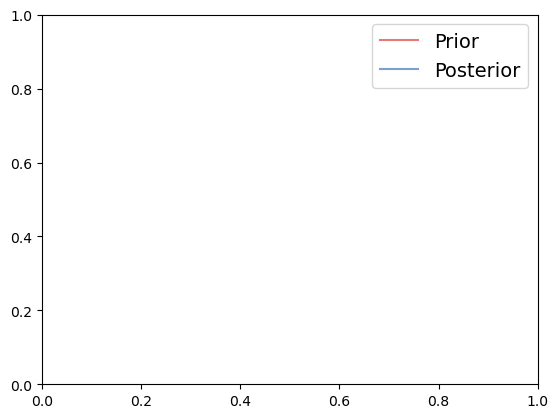

In [23]:
import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color=rosa, label='Prior')),
            (mlines.Line2D([], [], color=blue, label='Posterior'))
        ], loc="upper right", fontsize=14)

ValueError: x and y must be the same size

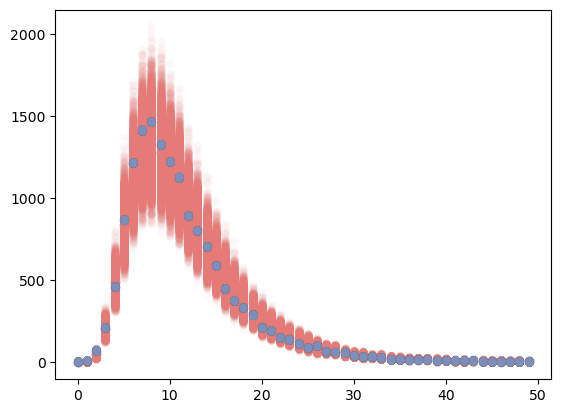

In [4]:

plotting.prior_posterior_predictives(model, act_aux_data, post_pred, prior_pred, 10)
plt.title('Sh4b, toy signal')
plt.xlabel('$m_{{SH}}$')

In [25]:
pyhf.set_backend('numpy')

pre_pred_nominal = cabinetry.model_utils.prediction(model).model_yields[0][0]
pre_pred_std = cabinetry.model_utils.prediction(model).total_stdev_model_bins[0][0]

fit_results = cabinetry.fit.fit(model, act_aux_data)
post_pred_nominal = cabinetry.model_utils.prediction(model, fit_results=fit_results).model_yields[0][0]
post_pred_std = cabinetry.model_utils.prediction(model, fit_results=fit_results).total_stdev_model_bins[0][0]

actual_data = data[:50]

In [36]:
def plot_MLE_posterior(model, fit_results):

    MLE_results = {}
    for i in range(len(model.config.parameters)):
        MLE_results[f'{fit_results.labels[i]}'] = fit_results.bestfit[i], fit_results.uncertainty[i]

    n_pars = len(model.config.parameters)
    fig, axes = plt.subplots(1, 3, figsize=[4.2*3, 2.53])

    plt_counter = 0
    for par in model.config.parameters:
        if '4' in str(par):
            continue
        else:
            posterior = np.concatenate(post_data.posterior[f'{par}'][0])

            posterior_m = sps.describe(posterior).mean
            posterior_s = np.sqrt(sps.describe(posterior).variance)

            mle_m, mle_s = MLE_results[f'{par}']

            axes[plt_counter].hist(posterior, bins=20, histtype='step', color=blue, linewidth=2, label = 'Bayesian: Posterior')
            axes[plt_counter].axvline(posterior_m, color=blue, linewidth=4, zorder=122, label='Bayesian: Posterior Mean')
            axes[plt_counter].axvspan(xmin = posterior_m - posterior_s, xmax = posterior_m + posterior_s, alpha=0.2, hatch='/', color=blue, label='Bayesian: Posterior Std')

            axes[plt_counter].axvline(mle_m, color=rosa, linewidth=4, zorder=122, label='Frequentist: MLE Mean')
            axes[plt_counter].axvspan(xmin = mle_m - mle_s, xmax = mle_m + mle_s, alpha=0.2, hatch='\\', color=rosa, label='Frequentist: MLE Std')
        

            axes[plt_counter].set_title(f'{par}')

            plt_counter += 1

    axes[0].set_ylabel('Draws')
    axes[0].legend(loc='upper left')

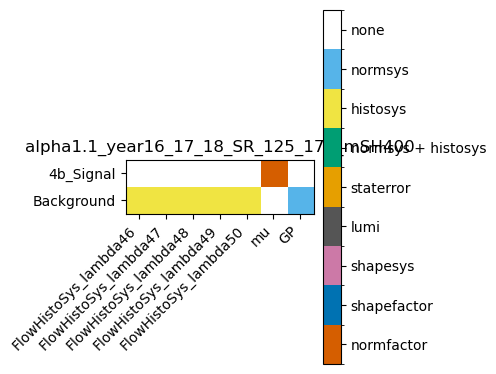

In [33]:
model, data = cabinetry.model_utils.model_and_data(workspace);
cabinetry.visualize.modifier_grid(model)

In [34]:
fit_results = cabinetry.fit.fit(model, data)

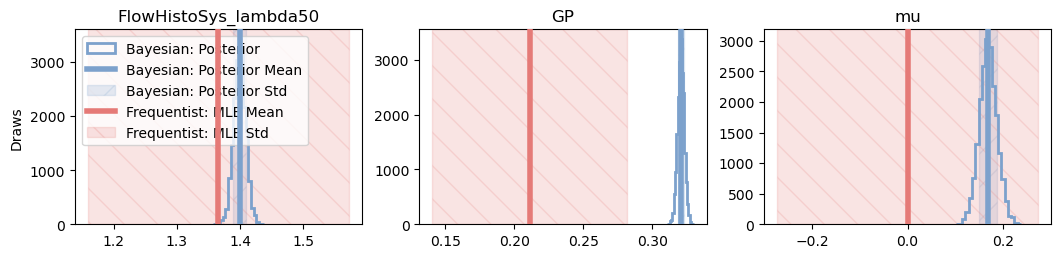

In [37]:
plot_MLE_posterior(model, fit_results=fit_results)

In [60]:
mSH_bins = [ 267.5,  302.5,  337.5,  372.5,  407.5,  442.5,  477.5,  512.5,
        547.5,  582.5,  617.5,  652.5,  687.5,  722.5,  757.5,  792.5,
        827.5,  862.5,  897.5,  932.5,  967.5, 1002.5, 1037.5, 1072.5,
       1107.5, 1142.5, 1177.5, 1212.5, 1247.5, 1282.5, 1317.5, 1352.5,
       1387.5, 1422.5, 1457.5, 1492.5, 1527.5, 1562.5, 1597.5, 1632.5,
       1667.5, 1702.5, 1737.5, 1772.5, 1807.5
       , 1842.5, 1877.5, 1912.5,
       1947.5, 1982.5]

In [61]:
mSH_bins

[267.5,
 302.5,
 337.5,
 372.5,
 407.5,
 442.5,
 477.5,
 512.5,
 547.5,
 582.5,
 617.5,
 652.5,
 687.5,
 722.5,
 757.5,
 792.5,
 827.5,
 862.5,
 897.5,
 932.5,
 967.5,
 1002.5,
 1037.5,
 1072.5,
 1107.5,
 1142.5,
 1177.5,
 1212.5,
 1247.5,
 1282.5,
 1317.5,
 1352.5,
 1387.5,
 1422.5,
 1457.5,
 1492.5,
 1527.5,
 1562.5,
 1597.5,
 1632.5,
 1667.5,
 1702.5,
 1737.5,
 1772.5,
 1807.5,
 1842.5,
 1877.5,
 1912.5,
 1947.5,
 1982.5]

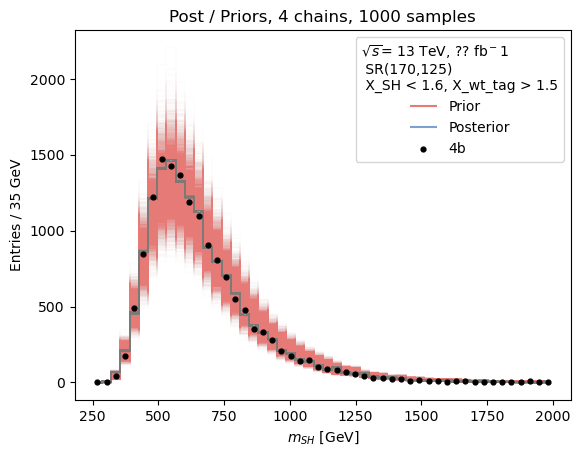

In [66]:
nBins = 50

# Prior
plt.step(np.linspace(np.array(mSH_bins).min(),np.array(mSH_bins).max(),nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.01, c = rosa, where = 'mid');
plt.vlines(mSH_bins,*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = rosa, label='Prior');

# Posterior
plt.step(np.linspace(np.array(mSH_bins).min(),np.array(mSH_bins).max(),nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = blue, where = 'mid');
plt.vlines(mSH_bins,*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = blue, label='Posterior')

# Observations
plt.scatter(mSH_bins, data, c = 'k',s=12, zorder = 999, label = "4b")
plt.legend(loc='upper right', title=r'$\sqrt{s}$' f'= 13 TeV, ?? fb$^{-1}$'
                                    +f' \n SR({mS},{125}) \n X_SH < 1.6, X_wt_tag > 1.5')

plt.title(f'Post / Priors, 4 chains, 1000 samples')


plt.ylabel(f'Entries / 35 GeV')#, fontsize=fontsize)
plt.xlabel(f'$m_{{SH}}$ [GeV]')#, fontsize=fontsize);

plt.show()